In this notebook, I am trying to:
1. do some basic raw data exploration, checking distribution, sanity checking, etc
2. basic feature transformation and analysis
3. feature correlation with labels

These steps will save a lot of time for later feature engineering and model development (feature selection, etc)

In [109]:
import pandas as pd
import dotenv
import os

import json

# 1. load raw data

>I did not include the raw data in this repo (since it is publicly accessible).
>
>If you want to re-run the notebook, please set your own `.env` file and add your data path to `RAW_DATA_PATH` (or provide the path directly here)

In [110]:
dotenv.load_dotenv('.env')
raw_data_path = os.getenv('RAW_DATA_PATH')

In [111]:
with open(raw_data_path, 'r') as file:
    raw_data_json = json.load(file)

raw_data = pd.json_normalize(raw_data_json)

In [112]:
raw_data.shape

(2000, 11)

In [113]:
raw_data.head()

,label,talent.languages,talent.job_roles,talent.seniority,talent.salary_expectation,talent.degree,job.languages,job.job_roles,job.seniorities,job.max_salary,job.min_degree
0,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, backend-developer, full-s...",junior,48000,bachelor,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
1,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, full-stack-developer, c-c...",junior,44000,master,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
2,True,"[{'rating': 'C2', 'title': 'English'}, {'ratin...","[frontend-developer, backend-developer, php-de...",senior,40000,none,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[php-developer],"[midlevel, senior]",65000,none
3,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, backend-developer, full-s...",junior,46000,apprenticeship,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
4,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[devops-engineer, frontend-developer, backend-...",midlevel,75000,master,"[{'title': 'German', 'rating': 'C1', 'must_hav...","[backend-developer, full-stack-developer]",[midlevel],80000,bachelor


# 2. label and original feature sanity check

After checking, i think this dataset itself is reletively clean except some missing values (not that many string data or outliers to deal with).

So there are not that many data cleaning steps we need to perform.

In [114]:
# check label distribution, looks balanced
raw_data['label'].value_counts()

label
True     1000
False    1000
Name: count, dtype: int64

In [115]:
# do some general sanity checking on data
# 1. we see some data missing on talent seniority, talent degree, and job degree, but overall looks good
# 2. salary range (max and min) from both talent and job side looks reasonable, no obvious outliers

description = raw_data.describe(include='all')
selected_stats = description.loc[['count', 'unique', 'top', 'freq', 'min', 'max']]

# add none count for each column
none_count = (raw_data == 'none').sum()
none_count.name = 'none_count'
selected_stats = pd.concat([selected_stats, none_count.to_frame().T])
selected_stats

,label,talent.languages,talent.job_roles,talent.seniority,talent.salary_expectation,talent.degree,job.languages,job.job_roles,job.seniorities,job.max_salary,job.min_degree
count,2000,2000,2000,2000,2000.0,2000,2000,2000,2000,2000.0,2000
unique,2,736,1367,4,NaN,5,22,35,28,NaN,5
top,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...",[frontend-developer],midlevel,NaN,bachelor,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",NaN,none
freq,1000,286,45,625,NaN,644,525,544,541,NaN,899
min,NaN,NaN,NaN,NaN,25000.0,NaN,NaN,NaN,NaN,45000.0,NaN
max,NaN,NaN,NaN,NaN,137080.0,NaN,NaN,NaN,NaN,100000.0,NaN
none_count,0,0,0,339,0.0,453,0,0,0,0.0,899


# 3. simple talent-job intersection feature transformation and sanity check on the transformed features

These features represent whether a talent's languages, job_roles, seniority, salary expectations, and, degree are within the requirements from the job side.

The benefit of having those features is that, with these features, you can even build a very basic rule based talent matching system as your baseline model.

Later on, we will also try to measure how good this system is. (it can also be possible that even some of the requirements are not met, the talent is still a good match to a job)

These features will also be part of the feature sets in our later ML model.

In [116]:
raw_data.head()

,label,talent.languages,talent.job_roles,talent.seniority,talent.salary_expectation,talent.degree,job.languages,job.job_roles,job.seniorities,job.max_salary,job.min_degree
0,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, backend-developer, full-s...",junior,48000,bachelor,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
1,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, full-stack-developer, c-c...",junior,44000,master,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
2,True,"[{'rating': 'C2', 'title': 'English'}, {'ratin...","[frontend-developer, backend-developer, php-de...",senior,40000,none,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[php-developer],"[midlevel, senior]",65000,none
3,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[frontend-developer, backend-developer, full-s...",junior,46000,apprenticeship,"[{'title': 'German', 'rating': 'C1', 'must_hav...",[frontend-developer],"[junior, midlevel]",70000,none
4,True,"[{'rating': 'C2', 'title': 'German'}, {'rating...","[devops-engineer, frontend-developer, backend-...",midlevel,75000,master,"[{'title': 'German', 'rating': 'C1', 'must_hav...","[backend-developer, full-stack-developer]",[midlevel],80000,bachelor


## 3.1 salary features

In [117]:
# salary_match_binary and salary_diff
# see whether talent's expected salary is below the max salary from the job side and the +- difference of them
raw_data_transformed = raw_data.assign(
    salary_match_binary=lambda df: df['talent.salary_expectation'] <= df['job.max_salary'],
    salary_diff=lambda df: (df['job.max_salary'] - df['talent.salary_expectation'])/ df['job.max_salary']
)

In [118]:
# roughly check distribution
raw_data_transformed.groupby('salary_match_binary')['label'].value_counts(normalize=True)

salary_match_binary  label
False                False    0.780000
                     True     0.220000
True                 True     0.706957
                     False    0.293043
Name: proportion, dtype: float64

In [119]:
# salary_bins: sometimes it does not matter that much between 80k and 81k, i want to normalize the salary to a few bins
salary_bins = [0, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, float('inf')]
salary_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

raw_data_transformed = raw_data_transformed.assign(
    talent_salary_bin=lambda df: pd.cut(df['talent.salary_expectation'], bins=salary_bins, labels=salary_labels, right=False),
    job_max_salary_bin=lambda df: pd.cut(df['job.max_salary'], bins=salary_bins, labels=salary_labels, right=False)
)

<Axes: xlabel='talent_salary_bin'>

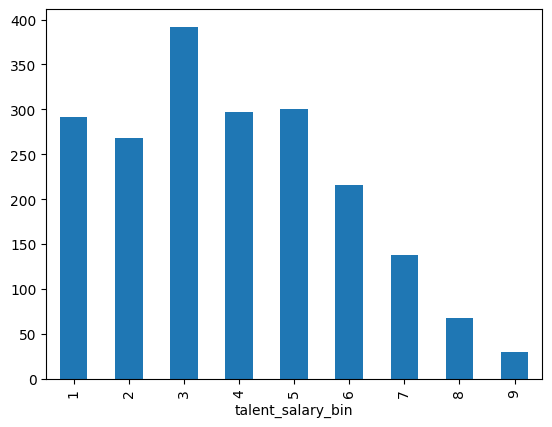

In [120]:
# roughly check distribution
raw_data_transformed['talent_salary_bin'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='job_max_salary_bin'>

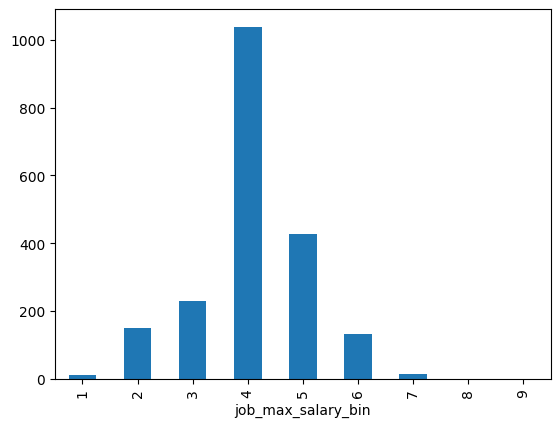

In [121]:
raw_data_transformed['job_max_salary_bin'].value_counts().sort_index().plot(kind='bar')

## 3.2 degree features

In [122]:
# degree_match_binary
# see if the talent's highest degree is met for the min degree requirements for the job
# but we first need to map the degree string to labels

unique_talent_degree = raw_data['talent.degree'].unique()
unique_job_degree = raw_data['job.min_degree'].unique()

print("Unique talent degree:", unique_talent_degree)
print("Unique job min degree:", unique_job_degree)

Unique talent degree: ['bachelor' 'master' 'none' 'apprenticeship' 'doctorate']
Unique job min degree: ['none' 'bachelor' 'master' 'apprenticeship' 'doctorate']


In [123]:
# define the mapping
degree_mapping = {
    'none': 0,
    'apprenticeship': 1,
    'bachelor': 2,
    'master': 3,
    'doctorate': 4
}

raw_data_transformed = raw_data_transformed.assign(
    talent_degree_label=lambda df: df['talent.degree'].map(degree_mapping),
    job_min_degree_label=lambda df: df['job.min_degree'].map(degree_mapping)
)

In [124]:
raw_data_transformed = raw_data_transformed.assign(
    degree_match_binary=lambda df: df['talent_degree_label'] >= df['job_min_degree_label']
)

In [125]:
# roughly check distribution, make sense on if degree is not a match, then 100% not a good match
raw_data_transformed.groupby('degree_match_binary')['label'].value_counts(normalize=True)

degree_match_binary  label
False                False    1.000000
True                 True     0.709723
                     False    0.290277
Name: proportion, dtype: float64

## 3.3 seniorities features

In [126]:
# seniority_match_binary: see whether the talent's seniority is with the job seniority
# seniority_exceed_binary: see whether the talent's seniority is above the job seniority
unique_talent_seniorities = raw_data['talent.seniority'].unique()
unique_job_seniorities = raw_data['job.seniorities'].explode().unique()

print("Unique talent seniorities:", unique_talent_seniorities)
print("Unique job seniorities:", unique_job_seniorities)

Unique talent seniorities: ['junior' 'senior' 'midlevel' 'none']
Unique job seniorities: ['junior' 'midlevel' 'senior' 'none']


In [127]:
seniority_mapping = {
    'none': 0,
    'junior': 1,
    'midlevel': 2,
    'senior': 3
}

In [128]:
raw_data_transformed = raw_data_transformed.assign(
    talent_seniority_label=lambda df: df['talent.seniority'].map(seniority_mapping),
    job_seniority_labels=lambda df: df['job.seniorities'].apply(
        lambda x: [seniority_mapping[seniority] for seniority in x]
    )
)

In [129]:
raw_data_transformed = raw_data_transformed.assign(
    seniority_match_binary=lambda df: df.apply(
        lambda row: row['talent_seniority_label'] in row['job_seniority_labels'], axis=1
    ),

    seniority_exceed_binary=lambda df: df.apply(
        lambda row: all(row['talent_seniority_label'] > label for label in row['job_seniority_labels']), axis=1
    )
)

In [130]:
# roughly check distribution, make sense -> if seniority not a match then label is not a match
raw_data_transformed.groupby('seniority_match_binary')['label'].value_counts(normalize=True)

seniority_match_binary  label
False                   False    1.000000
True                    True     0.705219
                        False    0.294781
Name: proportion, dtype: float64

In [131]:
# okay, seems this feature is useless, having seniority above the job requirement is not helpful
raw_data_transformed.groupby('seniority_exceed_binary')['label'].value_counts(normalize=True)

seniority_exceed_binary  label
False                    True     0.539374
                         False    0.460626
True                     False    1.000000
Name: proportion, dtype: float64

## 3.4 roles features

In [132]:
# job_roles_match_binary
# see if any of the job roles in the job is in talent's interested job roles.

In [133]:
def job_roles_match(talent_roles, job_roles):
    """check if there are intersections with talent and job roles"""
    return bool(set(talent_roles) & set(job_roles))

raw_data_transformed = raw_data_transformed.assign(
    job_roles_match_binary=lambda df: df.apply(
        lambda row: job_roles_match(row['talent.job_roles'], row['job.job_roles']), axis=1
    )
)

In [134]:
# roughly check distribution, make sense
raw_data_transformed.groupby('job_roles_match_binary')['label'].value_counts(normalize=True)

job_roles_match_binary  label
False                   False    1.000000
True                    True     0.725163
                        False    0.274837
Name: proportion, dtype: float64

## 3.5 language features

In [135]:
# language_must_have_match_binary: see if the talent meets the must have language requirements in jobs
# language_good2have_count: for those languages in job that are not must have, count how many of them are in talent's language pool (and meet requirements)
rating_mapping = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

def must_have_languages_match(talent_languages, job_languages):
    """check if the must have languages in job are in talent's language pool"""
    must_have_dict = {lang['title']: rating_mapping[lang['rating']] for lang in job_languages if lang['must_have']}
    talent_language_dict = {lang['title']: rating_mapping[lang['rating']] for lang in talent_languages}

    for title, required_rating in must_have_dict.items():
        if title not in talent_language_dict or talent_language_dict[title] < required_rating:
            return False
    return True


def count_good2have_languages(talent_languages, job_languages):
    """count how many non-must have languages are in talent's language pool"""
    good2have_dict = {lang['title']: rating_mapping[lang['rating']] for lang in job_languages if not lang['must_have']}
    talent_language_dict = {lang['title']: rating_mapping[lang['rating']] for lang in talent_languages}
    
    count = 0
    for title, required_rating in good2have_dict.items():
        if title in talent_language_dict and talent_language_dict[title] >= required_rating:
            count += 1
    
    return count

In [136]:
raw_data_transformed = raw_data_transformed.assign(
    language_must_have_match_binary=lambda df: df.apply(
        lambda row: must_have_languages_match(row['talent.languages'], row['job.languages']), axis=1
    ),
    language_good2have_count=lambda df: df.apply(
        lambda row: count_good2have_languages(row['talent.languages'], row['job.languages']), axis=1
    )
)

In [137]:
# sanity check on distribution, also make sense
raw_data_transformed.groupby('language_must_have_match_binary')['label'].value_counts(normalize=True)

language_must_have_match_binary  label
False                            False    1.000000
True                             True     0.694927
                                 False    0.305073
Name: proportion, dtype: float64

In [138]:
# sanity check on distribution, fair
raw_data_transformed.groupby('language_good2have_count')['label'].value_counts(normalize=True)

language_good2have_count  label
0                         False    0.516308
                          True     0.483692
1                         True     0.560440
                          False    0.439560
2                         True     0.909091
                          False    0.090909
Name: proportion, dtype: float64

## 3.6 other minor sanity check

In [139]:
# for all matched pairs (label == true), check if all job_roles are in talent's interested roles
# why? -> if it is not the case, then the matching based on job_roles feels bit loose

raw_data_transformed[raw_data_transformed['label']]['job_roles_match_binary'].value_counts(normalize=True)

job_roles_match_binary
True    1.0
Name: proportion, dtype: float64

In [140]:
# for all matched pairs (label == true), check if all job max salary >= talent's expected salary
# why? -> if it is not the case, then it means that talent can sometimes accept the job with salary lower than their expectations, then the salary_difference feature can make sense

raw_data_transformed[raw_data_transformed['label']]['salary_match_binary'].value_counts(normalize=True)

salary_match_binary
True     0.813
False    0.187
Name: proportion, dtype: float64

# 4. correlation analysis

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

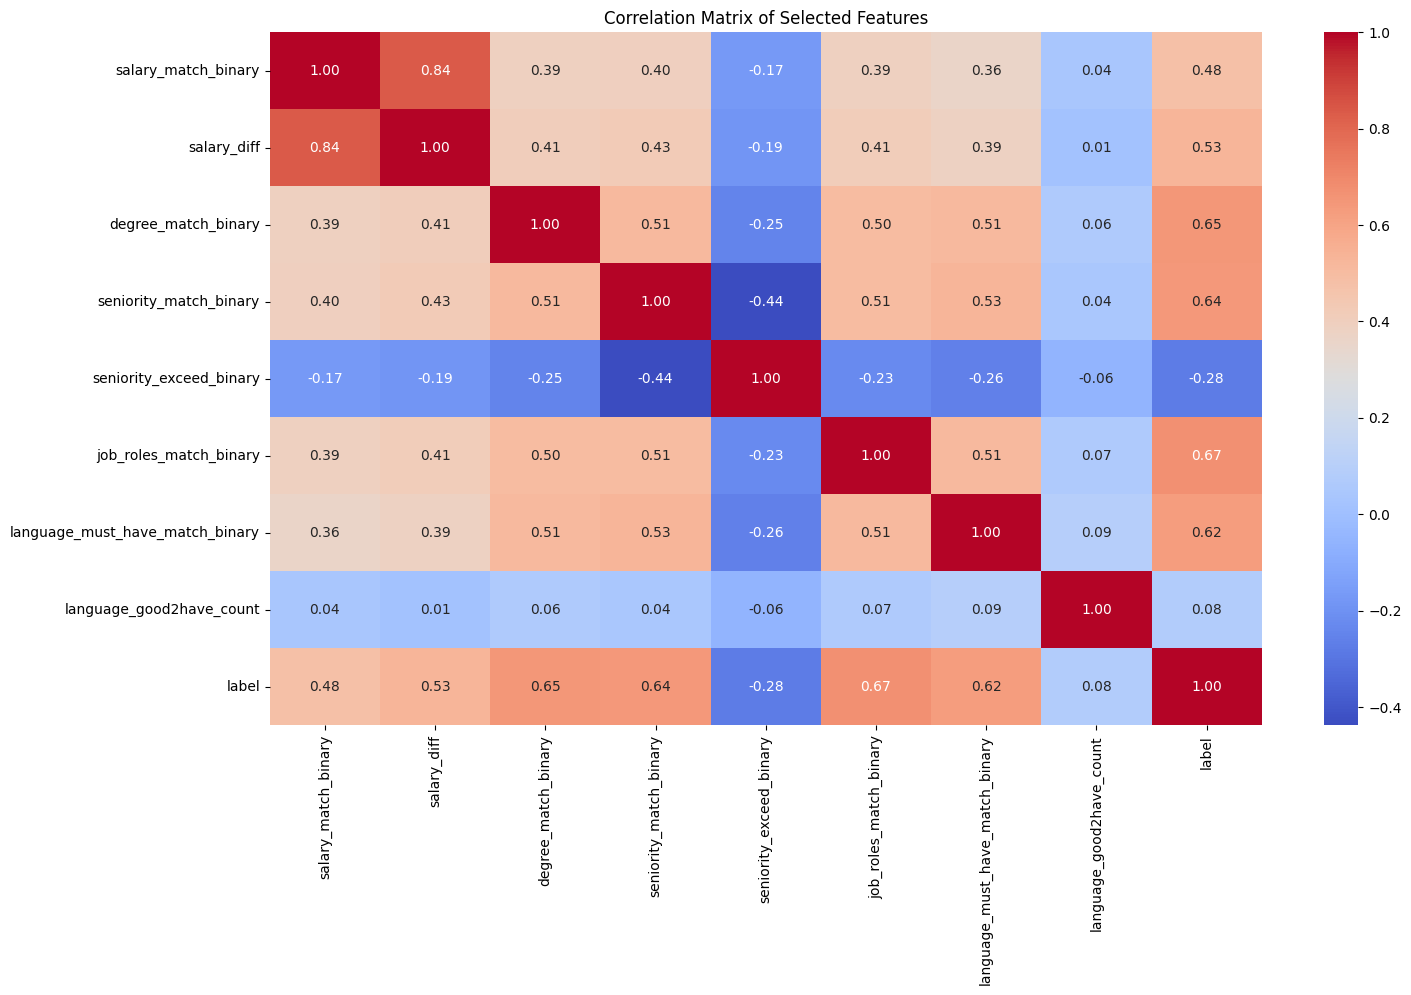

In [142]:
# we do see the strong positive and negative correlations with the label from those features
# which means that choosing a basic linear model like logistic regression might be a good start
# but at the same time we see that these features themselves are also strongly correlated to each other, which can cause problems like multicollinearity (overfitting, unstable coefficients, etc)
# in real projects, we might need to further do feature ablation/selection afterwards
# here let's first try with
# 1. adding all those features
# 2. add the original features themselves as well in case that the model can capture other correlations from talent/job side as well
# 3. add regularization to mitigate overfitting problem from multicollinearity

selected_cols = [
    'salary_match_binary',
    'salary_diff',
    'degree_match_binary',
    'seniority_match_binary',
    'seniority_exceed_binary',
    'job_roles_match_binary',
    'language_must_have_match_binary',
    'language_good2have_count',
    'label'
]
correlation_matrix = raw_data_transformed[selected_cols].corr(method='pearson') # linear

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()